## Vascular density workflow

[file] is something like

```
/Users/cudmore/box/data/nathan/20200116/20190116__A01_G001_0019_ch1.tif
```

 1. Set [file] (firstSlice, lastSlice) in master_cell_db.csv
 
 2. Run main analysis, creates a bunch of .tif files in folder analysis2/
 ```
 python vascDen.py [file]
 ```
 
 3. Generate convex hull. Creates analysis2/ _finalMask_hull.tif)
 ```
 /Users/cudmore/Sites/skan/skanenv/bin/python myConvexHull.py [file]
 ```
 
 4. Interactively remove large vessels with Napari interface. Creates analysis2/ _labeled_edited.tif
 ```
 python python vascDenNapari.py [file]
 ```
 
 5. Generate edt. Creates analysis2/ _finalMask_edt.tif
 ```
 # note [file] here is using myDataPath.py
 # looks like '20200116/20190116__A01_G001_0007_ch1.tif'
 python vascEDT.py [file]
 ```

 6. Run the code in this notebook to generate vascular percentage
 

## For each stack analysis, split it up into a grid and calculate the density of vessels

In [76]:
import numpy as np

import scipy

import tifffile

import matplotlib
import matplotlib.pyplot as plt


### Function to calculate density grid

 - Each pixel in results is percent vascular mask = (pixels in mask / pixels in hull) * 100
 - Each pixel is the mean percent vascular mask through all image slices (may change)

In [224]:
def myDensityGrid(editedLabels, hull, origNumLabel, numInGrid=4):

    numSlices = editedLabels.shape[0]

    start = 0
    numRows = editedLabels.shape[1]
    numCols = editedLabels.shape[2]

    # todo: np.linspace() is SUPER confusing
    xGrid, xStep = np.linspace(start, numRows, numInGrid, endpoint=False, retstep=True, dtype=np.uint16)
    yGrid, yStep = np.linspace(start, numCols, numInGrid, endpoint=False, retstep=True, dtype=np.uint16)

    xStep = int(xStep) # np.linspace() returns float ... convert to int
    yStep = int(yStep)

    numGridRows = len(xGrid)
    numGridCols = len(yGrid)

    # make a (numGridRows x numGridCols) image of percent vascular mask
    # for now, take (vasculare picels / hull pixels) of each pixel as the MEAN through all slices ???

    densityImage = np.ndarray((numGridRows, numGridCols))
    
    # each pixel in final image has a histogram of fractions as a function of depth
    hullFractionMatrix = np.ndarray((numGridRows, numGridCols, numSlices))
    sliceFractionMatrix = np.ndarray((numGridRows, numGridCols, numSlices))
    
    for row in range(numGridRows):
        startRow = xGrid[row]
        stopRow = startRow + xStep - 1

        for col in range(numGridCols):
            startCol = yGrid[col]
            stopCol = startCol + yStep -1
        
            # z
            hullSliceList = []
            editedSliceList = []
            hullFraction = []
            sliceFraction = []
            for sliceIdx in range(numSlices):
                # want the stats as the sum of vasculature mask normalized to sum of _hull ???
                # if the hull at a slice is None then None 
            
                # hull
                hullGrid = hull[sliceIdx,startRow:stopRow,startCol:stopCol]
                nHull = np.count_nonzero(hullGrid)
                if nHull == 0:
                    nHull = np.nan
                thisHullFraction = nHull / hullGrid.size * 100
                hullFraction.append(thisHullFraction) # because we are taking the mean, we really need to look at sliceFracti        
                hullSliceList.append(nHull)
            
                # editedLabels
                editedLabelsGrid = editedLabels[sliceIdx,startRow:stopRow,startCol:stopCol]
                #
                # use origNumLabel
                editedLabelsGrid = editedLabelsGrid[editedLabelsGrid<=origNumLabel]
                nEdited = np.count_nonzero(editedLabelsGrid)
                if nEdited == 0:
                    nEdited = np.nan
                editedSliceList.append(nEdited)
            
                # fraction of mask in hull
                thisFraction = nEdited / nHull * 100
                sliceFraction.append(thisFraction) # because we are taking the mean, we really need to look at sliceFraction as function of z

            # in for (row, col)
            '''
            if np.all(np.isnan(hullSliceList)):
                hullMean = np.nan
            else:
                hullMean = np.nanmean(hullSliceList)
            if np.all(np.isnan(editedSliceList)):
                editedMean = np.nan
            else:
                editedMean = np.nanmean(editedSliceList)
            ''';
            if np.all(np.isnan(sliceFraction)):
                editedFraction = np.nan
            else:
                editedFraction = np.nanmean(sliceFraction)
            #
            densityImage[row,col] = editedFraction
            sliceFractionMatrix[row,col] = sliceFraction
            hullFractionMatrix[row,col] = hullFraction
            
    #print('done')
    return densityImage, sliceFractionMatrix, hullFractionMatrix


## Load one file

In [225]:

# fileIdxList = ['0007', '0010', '0011', '0014', '0015', '0018', '0019', '0022', '0023', '0027']
# 0028 is not in grid, just do it here for now
fileIdx = '0007'

labeledPath = f'/Users/cudmore/box/data/nathan/20200116/analysis2/20190116__A01_G001_{fileIdx}_ch1_labeled.tif'
editedLabelsPath = f'/Users/cudmore/box/data/nathan/20200116/analysis2/20190116__A01_G001_{fileIdx}_ch1_labeled_edited.tif'
hullPath = f'/Users/cudmore/box/data/nathan/20200116/analysis2/20190116__A01_G001_{fileIdx}_ch1_finalMask_hull.tif'

labeled = tifffile.imread(labeledPath)
editedLabels = tifffile.imread(editedLabelsPath)
hull = tifffile.imread(hullPath)

origNumLabels = np.nanmax(labeled)
print('origNumLabels:', origNumLabels)

print('loaded fileIdx:', fileIdx)

origNumLabels: 281
loaded fileIdx: 0007


## Plot one file

tmpNumInGrid: 4


/Users/cudmore/Sites/bImPy/bImPy_env/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


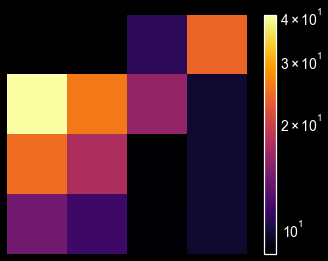

In [226]:
tmpNumInGrid = 4
print('tmpNumInGrid:', tmpNumInGrid)


densityImage, sliceFractionMatrix, hullFractionMatrix = myDensityGrid(editedLabels, hull, origNumLabels, numInGrid=tmpNumInGrid)

myMin = np.nanmin(densityImage)
myMax = np.nanmax(densityImage)
my_cmap = 'inferno' # see: https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html
norm = LogNorm(vmin=myMin, vmax=myMax)
plt.imshow(densityImage, norm=norm, cmap=my_cmap)

plt.axis('off')
plt.colorbar();

## For each pixel, plot vasc density as a function of depth

In [227]:
#import matplotlib
params = {'legend.fontsize': 18,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'ytick.labelsize' :14,
      'xtick.labelsize' :14,
      "xtick.bottom" : True,
      "ytick.left" : True,
      }
matplotlib.rcParams.update(params)

tmpNumInGrid: 4
vascular fraction: green is mean, megenta +/- std


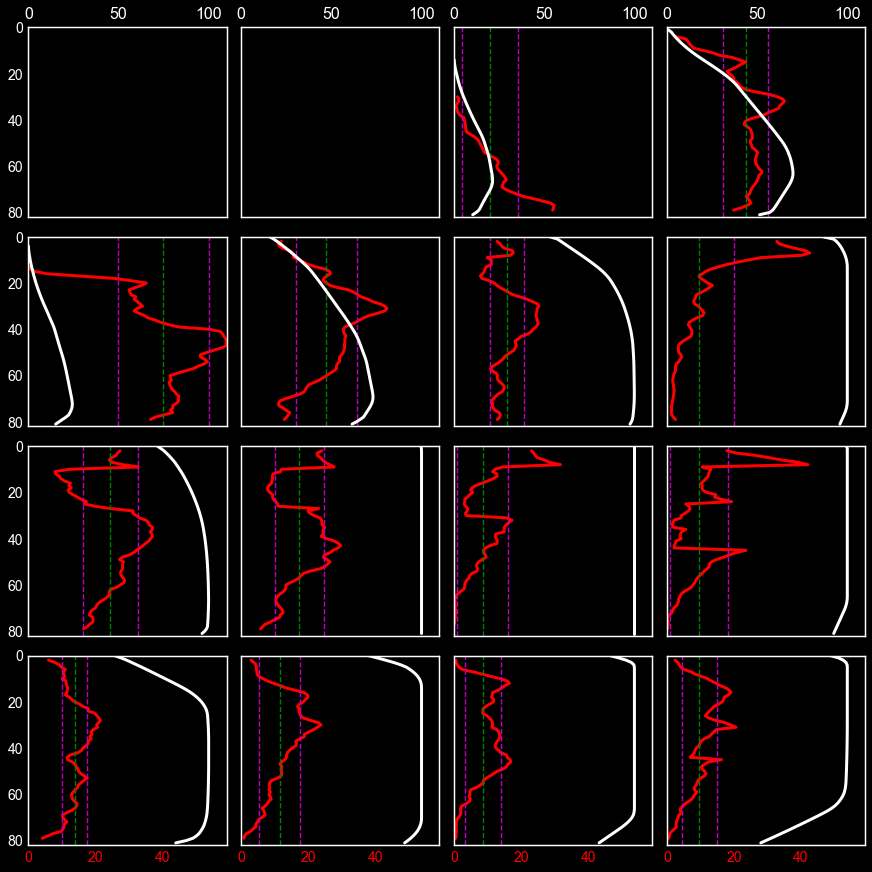

In [247]:
print('tmpNumInGrid:', tmpNumInGrid)

plt.style.use("dark_background") # seaborn-paper

numSlices = sliceFractionMatrix.shape[2]
sliceList = [z for z in range(numSlices)]

fig, axs = plt.subplots(nrows=tmpNumInGrid, ncols=tmpNumInGrid,
                        sharex=True, sharey=True, figsize=(12,12), constrained_layout=True)
axs = np.ravel(axs)

myFontSizeSmaller = 16
myLineWidth = 3
xVascMax = 0 # keep track of x-axes max to set all pixel plots to the same
xHullMax = 0

subplotIdx = 0
secondAxesList = []
for row in range(tmpNumInGrid):
    for col in range(tmpNumInGrid):
        oneHullFraction = hullFractionMatrix[row,col] # 1d of hull fraction per slice
        onePixelFraction = sliceFractionMatrix[row,col] # as a function of depth

            
        #axs[subplotIdx].plot(oneHullFraction, sliceList, 'w')
        axs[subplotIdx].plot(onePixelFraction, sliceList, linewidth=myLineWidth, color='r')
        axs[subplotIdx].set_ylim(numSlices, 0) # reversed
        
        if not np.all(np.isnan(onePixelFraction)):
            vascPixelMax = np.nanmax(onePixelFraction)
            if vascPixelMax >xVascMax:
                xVascMax = vascPixelMax
            #
            xMean = np.nanmean(onePixelFraction)
            xStd = np.nanstd(onePixelFraction)
            minusStd = xMean - xStd
            plusStd = xMean + xStd
            #xMedian = np.nanmedian(onePixelFraction)
            axs[subplotIdx].axvline(x=xMean, color='g', linestyle='--')
            axs[subplotIdx].axvline(x=minusStd, color='m', linestyle='--')
            axs[subplotIdx].axvline(x=plusStd, color='m', linestyle='--')
            #axs[subplotIdx].axvline(x=xMedian, color='m', linestyle='--')
        
        # 2nd. top axes for hull fraction
        ax2 = axs[subplotIdx].twiny()
        secondAxesList.append(ax2)
        l2, = secondAxesList[subplotIdx].plot(oneHullFraction,sliceList, linewidth=myLineWidth, color='w')
        #secondAxesList[subplotIdx].set_xlabel('Vasculature Volume (%)', fontsize = myFontSizeSmaller, color='r')
        #secondAxesList[subplotIdx].tick_params(axis='x', labelsize=myFontSizeSmaller, colors='r') 
        #secondAxesList[subplotIdx].spines['right'].set_visible(False)
        if not np.all(np.isnan(oneHullFraction)):
            hullPixelMax = np.nanmax(oneHullFraction)
            if hullPixelMax >xHullMax:
                xHullMax = hullPixelMax + (hullPixelMax*0.1)


        #
        if row==0:
            axs[subplotIdx].tick_params(axis='x', labelsize=myFontSizeSmaller, colors='r') 
            secondAxesList[subplotIdx].tick_params(axis='x', labelsize=myFontSizeSmaller, colors='w') 
        else:
            # off
            #secondAxesList[idx].set_ticklabels(False)
            axs[subplotIdx].tick_params(axis='x', colors='r', labeltop=False) 
            secondAxesList[subplotIdx].tick_params(axis='x', colors='w', labeltop=False) 

        #
        subplotIdx += 1


for idx in range(len(axs)):
    axs[idx].set_xlim(0,xVascMax) # so each plot looks same
    secondAxesList[idx].set_xlim(0,xHullMax) # so each plot looks same


# this is annoying, does not work
#fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
#fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

print('vascular fraction: green is mean, megenta +/- std')

## Do again for all images in grid

 - With densityImage of each stack, force a range of color from min/max across all densityImage


## Load all analysis

In [198]:
editedList = []
hullList = []
origNumLabelsList = []
edtList = []

fileIdxList = ['0007', '0010', '0011', '0014', '0015', '0018', '0019', '0022', '0023', '0027']
idxList = [0, 2, 3, 5, 4, 6, 7, 9, 8, 11] # index into subplots of original matrix (snaking)
# 28 is not in grid

for fileIdx in fileIdxList:
    print('loading fileIdx:', fileIdx)
    
    labeledPath = f'/Users/cudmore/box/data/nathan/20200116/analysis2/20190116__A01_G001_{fileIdx}_ch1_labeled.tif'
    editedLabelsPath = f'/Users/cudmore/box/data/nathan/20200116/analysis2/20190116__A01_G001_{fileIdx}_ch1_labeled_edited.tif'
    hullPath = f'/Users/cudmore/box/data/nathan/20200116/analysis2/20190116__A01_G001_{fileIdx}_ch1_finalMask_hull.tif'
    edtPath = f'/Users/cudmore/box/data/nathan/20200116/analysis2/20190116__A01_G001_{fileIdx}_ch1_finalMask_edt.tif'

    labeled = tifffile.imread(labeledPath)
    origNumLabels = np.nanmax(labeled)
    origNumLabelsList.append(origNumLabels)

    editedLabels = tifffile.imread(editedLabelsPath)
    editedList.append(editedLabels)

    hull = tifffile.imread(hullPath)
    hullList.append(hull)

    edt = tifffile.imread(edtPath)
    edtList.append(edt)
 
    #idxList.append(0)

print('done')

loading fileIdx: 0007
loading fileIdx: 0010
loading fileIdx: 0011
loading fileIdx: 0014
loading fileIdx: 0015
loading fileIdx: 0018
loading fileIdx: 0019
loading fileIdx: 0022
loading fileIdx: 0023
loading fileIdx: 0027
done


## Plot in a grid

Sorry, This takes some work in using matplotlib

. file: 0007 min: 8.47 max: 40.31
. file: 0010 min: 2.71 max: 15.74
. file: 0011 min: 5.41 max: 20.13
. file: 0014 min: 1.64 max: 12.01
. file: 0015 min: 1.45 max: 9.83
. file: 0018 min: 2.52 max: 17.83
. file: 0019 min: 0.09 max: 6.41
. file: 0022 min: 0.02 max: 8.07
. file: 0023 min: 0.03 max: 13.19
. file: 0027 min: 0.01 max: 12.7


/Users/cudmore/Sites/bImPy/bImPy_env/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


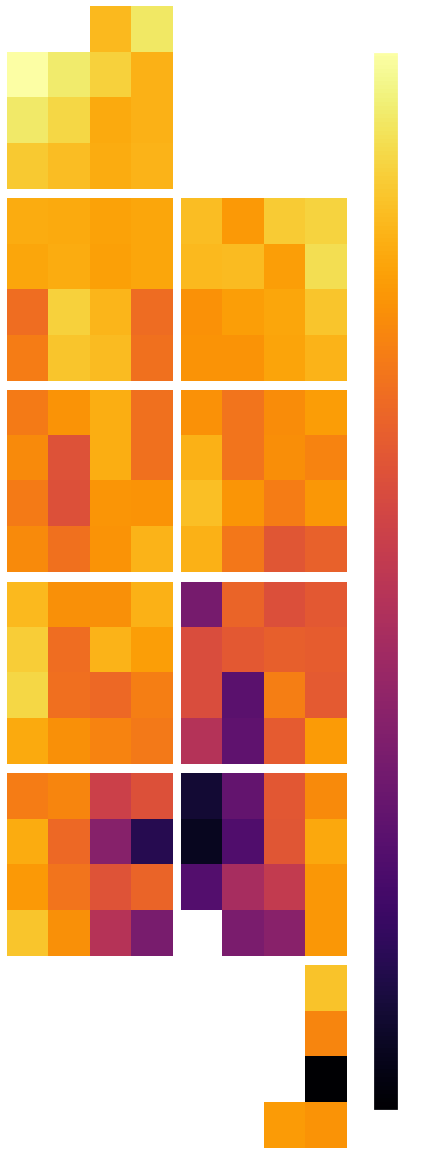

In [155]:
## Make plots on black background (for slides)
#sns.set(style="ticks", context="talk")
plt.style.use("dark_background") # seaborn-paper
#plt.style.use("seaborn-paper") # seaborn-paper
#plt.style.use("seaborn-white") # seaborn-paper

numInGrid = 4

globalMin = 100
globalMax = 0

# collect density images and get global min/max
densityImageList = []
for idx in range(len(editedList)):
    editedData = editedList[idx]
    hullData = hullList[idx]
    origNumLabel = origNumLabelsList[idx]
    subplotIdx = idxList[idx]
    fileIdx = fileIdxList[idx]    
    
    densityImage, sliceFractionMatrix, hullFractionMatrix = myDensityGrid(editedData, hullData, origNumLabel, numInGrid=numInGrid)
    densityImageList.append(densityImage)
    
    theMin = np.nanmin(densityImage)
    theMax = np.nanmax(densityImage)
    print('. file:', fileIdx, 'min:', round(theMin,2), 'max:', round(theMax,2))
    
    if theMin < globalMin:
        globalMin = theMin
    if theMax > globalMax:
        globalMax = theMax
        

#
# plot density images with global min/max

nrow = 6
ncol = 2
showTitles = False # add a title to each subplot (stack)
myTitleSize = 16
my_cmap = 'inferno' # see: https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, sharey=False, figsize=(7,21), constrained_layout=False)
axs = np.ravel(axs)
fig.patch.set_alpha(0.0) # to make background (black) transparent

for ax in axs:
    ax.axis('off')

for idx, densityImage in enumerate(densityImageList):
    subplotIdx = idxList[idx]
    fileIdx = fileIdxList[idx]    
    #densityImage = densityImageList[masterIdx]


    # linear
    #im = axs[subplotIdx].imshow(densityImage, vmin=globalMin, vmax=globalMax)

    # log with norm=LogNorm(vmin=0.01, vmax=1)
    norm = matplotlib.colors.LogNorm(vmin=globalMin, vmax=globalMax)
    im = axs[subplotIdx].imshow(densityImage, norm=norm, aspect='auto', cmap=my_cmap)
    
    axs[subplotIdx].axis('off')
            
    # evetually remove this
    if showTitles:
        titleStr = str(subplotIdx) + ' / file:' + str(fileIdx)
        axs[subplotIdx].set_title(titleStr, size=myTitleSize)
        
# eventually get everything smooshed together
if showTitles:
    plt.tight_layout()
else:
    wspace = 0.05 # units??? inches???
    hspace = 0.05
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

# this does nothing
#matplotlib.colors.Normalize(vmin=globalMin, vmax=globalMax, clip=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax);
cb.ax.tick_params(labelsize=myTitleSize)


In [195]:
def _printStackParams(name, myStack):
    print('  ', name, myStack.shape, myStack.dtype, 'dtype.char:', myStack.dtype.char,
        'min:', round(np.min(myStack),2), 'max:', round(np.max(myStack),2), 'mean:', round(np.nanmean(myStack),2))

## Plot histogram of edt for each stack

   edtData (22608959,) float32 dtype.char: f min: 1.08 max: 33.36 mean: 5.19
.    file:0007 mean= 5.19 sigma= 9.64
   edtData (26451428,) float32 dtype.char: f min: 1.08 max: 52.9 mean: 6.65
.    file:0010 mean= 6.65 sigma= 7.21
   edtData (26122793,) float32 dtype.char: f min: 1.08 max: 30.62 mean: 6.06
.    file:0011 mean= 6.06 sigma= 7.54
   edtData (24645213,) float32 dtype.char: f min: 1.08 max: 38.39 mean: 8.95
.    file:0014 mean= 8.95 sigma= 8.06
   edtData (17694037,) float32 dtype.char: f min: 1.08 max: 39.65 mean: 8.98
.    file:0015 mean= 8.98 sigma= 10.58
   edtData (7999852,) float32 dtype.char: f min: 1.08 max: 44.29 mean: 10.68
.    file:0018 sigma= 10.58
   edtData (16261668,) float32 dtype.char: f min: 1.08 max: 54.29 mean: 13.18
.    file:0019 mean= 13.18 sigma= 11.65
   edtData (10837726,) float32 dtype.char: f min: 1.08 max: 65.47 mean: 17.28
.    file:0022 mean= 17.28 sigma= 62.54
   edtData (13246815,) float32 dtype.char: f min: 1.08 max: 59.22 mean: 11.28
.    f

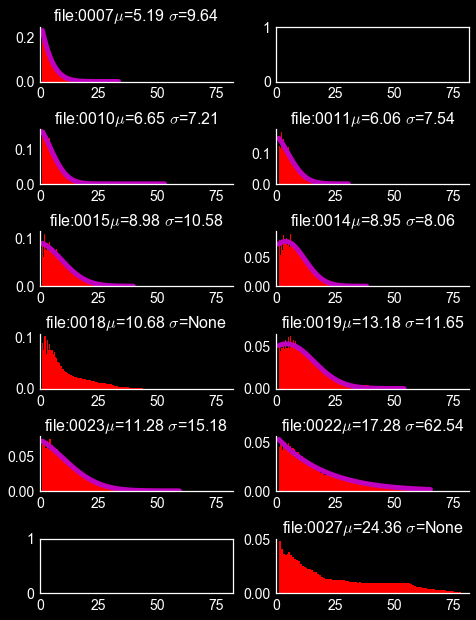

In [256]:
#from scipy.optimize import curve_fit # todo: switch this to scipy.optimize.curve_fit

def myGaussianFit(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, sharey=False, figsize=(6.5,8.5), constrained_layout=True)
axs = np.ravel(axs)

myBins = 100
hist = True
kde = False # kde: Whether to plot a gaussian kernel density estimate (if True ... VERY SLOW)
norm_hist = True

hist_kws = {
    'alpha':0.5, # set to 1 so colors do not 'sum'
    'cumulative':False
}

#colorList = ['r', 'g', 'b']
showTitles = True

# histogram
xPlotMax = 0
for idx, edtData in enumerate(edtList):

    subplotIdx = idxList[idx]
    fileIdx = fileIdxList[idx]    
    #titleStr = str(subplotIdx) + ' / file:' + str(fileIdx)
    titleStr = 'file:' + str(fileIdx)# will append $\sigma$=
    ax = axs[subplotIdx]
    
    edtData = edtData.copy()
    
    # flatten edt, remove np.nan and remove distance <= 1.0 (um)
    edtData = np.ravel(edtData)
    edtData = edtData[~np.isnan(edtData)]
    edtData[edtData<=1] = np.nan
    edtData = edtData[~np.isnan(edtData)]
    
    _printStackParams('edtData', edtData)
    
    meanedt = np.nanmean(edtData) # for titleStr
    meanedt = round(meanedt,2)
    
    #stackData = stackData[~np.isnan(stackData)]
    color = 'r' #colorList[idx]
 
    # plot histogram
    counts, bins, bars = ax.hist(edtData, bins=myBins, density=True, color=color)
    
    xStart = np.min(bins)
    xStop = np.max(bins)
    if xStop > xPlotMax:
        xPlotMax = xStop
    x = np.linspace(xStart,xStop,myBins) # Example data
    y = counts
    # weighted arithmetic mean
    gMean = sum(x * y) / sum(y)
    gSigma = np.sqrt(sum(y * (x - gMean)**2) / sum(y))
    #print('initial gaussian gMean:', gMean, 'gSigma:', gSigma)
    #poptGaus, pcovGaus = scipy.optimize.curve_fit(myGaussianFit,x,y,p0=(1.0,1.0,1.0)) # max(y), mean, sigma
    try:
        poptGaus, pcovGaus = scipy.optimize.curve_fit(myGaussianFit,x,y,p0=(max(y), gMean, gSigma)) # max(y), mean, sigma

        #print('poptGaus:', poptGaus) # best fit parameters
        gaus1 = poptGaus[0] # a
        gaus2 = poptGaus[1] # x0
        gaus3 = poptGaus[2] # sigma

        sigma = round(gaus3,2)
        print('.   ', titleStr, 'mean=', meanedt, 'sigma=', sigma)
        titleStr += ' $\mu$=' + str(meanedt) + ' $\sigma$=' + str(sigma)
    
        # to plot the fit
        xFit = x
        yFit = myGaussianFit(x,gaus1, gaus2, gaus3)

        # plot the fit
        fitColor = 'm' + '-'
        ax.plot(xFit, yFit, fitColor, lw=5)

    except (RuntimeError) as e:
        print('.   ', titleStr, 'sigma=', sigma)
        titleStr += ' $\mu$=' + str(meanedt) + ' $\sigma$=' + 'None'

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set x tick labels to integer
    #xlabels = [str(int(x)) for x in ax.get_xticks().tolist()] # used below
    #ax.set_xticklabels(xlabels) # using from above

    if showTitles:
        ax.set_title(titleStr, size=myTitleSize)
 
# set all x-axis
for ax in axs:
    ax.set_xlim(0,xPlotMax) # so each plot looks same

